In [1]:
import pandas as pd
import numpy as np
import json
import gmaps
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import requests
from scipy.stats import linregress
import matplotlib.cm as cm

#from census import Census
from config import gkey

import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

gmaps.configure(api_key=gkey)


In [2]:
file = "Resources/Austin Data Set CSV.csv"
base_df = pd.read_csv(file)

# pd.set_option("display.max_rows", 15)

base_df.head()

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,...,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432672,-97.661697,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,True,...,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,True,...,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg


In [3]:

# we should rule out the outliers, below is a breakout that shows some homes have 27 rooms and 20 bathrooms.  

In [4]:
mask = base_df.city == 'austin'
newDf = base_df[mask].reset_index()
newDf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15020 entries, 0 to 15019
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       15020 non-null  int64  
 1   zpid                        15020 non-null  int64  
 2   city                        15020 non-null  object 
 3   streetAddress               15020 non-null  object 
 4   zipcode                     15020 non-null  int64  
 5   description                 15020 non-null  object 
 6   latitude                    15020 non-null  float64
 7   longitude                   15020 non-null  float64
 8   propertyTaxRate             15020 non-null  float64
 9   garageSpaces                15020 non-null  int64  
 10  hasAssociation              15020 non-null  bool   
 11  hasCooling                  15020 non-null  bool   
 12  hasGarage                   15020 non-null  bool   
 13  hasHeating                  150

In [5]:
mask = newDf.lotSizeSqFt != 1508482800.0
cleanDf = newDf[mask]
cleanDf.describe()

,index,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
count,15019.000000,1.501900e+04,15019.000000,15019.000000,15019.000000,15019.000000,15019.000000,15019.000000,15019.000000,1.501900e+04,...,15019.000000,15019.000000,15019.000000,15019.000000,15019.000000,15019.000000,15019.000000,15019.000000,15019.000000,15019.000000
mean,7645.484853,1.034826e+08,78736.921433,30.292187,-97.779470,1.994193,1.230441,1.225714,1988.347160,5.147095e+05,...,0.048805,1.035888,0.976896,1.840638,5.799901,1235.715361,14.866236,2.683431,3.439843,1.468274
std,4351.997721,3.169948e+08,15.841007,0.096616,0.083836,0.053351,1.351113,1.351738,21.569163,4.542934e+05,...,0.232988,0.264121,0.292056,1.064699,1.852850,326.527599,1.745192,1.055014,0.851327,0.524003
min,17.000000,2.858495e+07,78652.000000,30.085030,-98.022057,1.980000,0.000000,0.000000,1905.000000,5.500000e+03,...,0.000000,0.000000,0.000000,0.200000,2.333333,396.000000,10.000000,0.000000,0.000000,1.000000
25%,3888.500000,2.941047e+07,78727.000000,30.204472,-97.838570,1.980000,0.000000,0.000000,1974.000000,3.100000e+05,...,0.000000,1.000000,1.000000,1.100000,4.000000,966.000000,14.000000,2.000000,3.000000,1.000000
50%,7655.000000,2.949329e+07,78739.000000,30.285294,-97.770065,1.980000,1.000000,1.000000,1993.000000,4.090000e+05,...,0.000000,1.000000,1.000000,1.566667,6.000000,1287.000000,15.000000,3.000000,3.000000,1.000000
75%,11412.500000,7.033528e+07,78749.000000,30.366622,-97.719181,1.980000,2.000000,2.000000,2006.000000,5.750000e+05,...,0.000000,1.000000,1.000000,2.266667,7.000000,1494.000000,16.000000,3.000000,4.000000,2.000000
max,15170.000000,2.146313e+09,78759.000000,30.517323,-97.569504,2.210000,22.000000,22.000000,2020.000000,1.350000e+07,...,2.000000,3.000000,2.000000,7.700000,9.500000,1913.000000,19.000000,27.000000,20.000000,4.000000


In [6]:
squareFoot = cleanDf['livingAreaSqFt']
quartiles = squareFoot.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq



lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

mask = cleanDf['livingAreaSqFt'] < upper_bound
outlierGoneDf = cleanDf[mask]


latestPrice = cleanDf['latestPrice']
quartiles = latestPrice.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq



lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

mask = outlierGoneDf['latestPrice'] < upper_bound
outlierGoneDf = outlierGoneDf[mask]
outlierGoneDf['latestPrice']

mask = outlierGoneDf['latestPrice'] > lower_bound
outlierGoneDf = outlierGoneDf[mask]


Values below -320.25 could be outliers.
Values above 4493.75 could be outliers.
Values below -87500.0 could be outliers.
Values above 972500.0 could be outliers.


In [7]:
feature = outlierGoneDf[["livingAreaSqFt",'propertyTaxRate','numOfBedrooms','numOfBathrooms','yearBuilt']]
target = outlierGoneDf["latestPrice"]

# STATSMODELS
X = sm.add_constant(feature)
Y = target

model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            latestPrice   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     1779.
Date:                Sun, 01 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:33:45   Log-Likelihood:            -1.8295e+05
No. Observations:               13838   AIC:                         3.659e+05
Df Residuals:                   13832   BIC:                         3.660e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.149e+06   1.25e+05     49.224      0.000     5.9e+06    6.39e+06
livingAreaSqFt    157.6725      2.440     64.633      0.000     152.891     162.454
propertyTaxRate -3.342e+05   2.09e+04    -15.983      0.000   -3.75e+05   -2.93e+05
numOfBedrooms    -3.79e+04   1926.982    -19.668      0.000   -4.17e+04   -3.41e+04
numOfBathrooms   2.344e+04   1990.142     11.778      0.000    1.95e+04    2.73e+04
yearBuilt       -2671.2825     61.688    -43.303      0.000   -2792.200   -2550.365
==============================================================================
Omnibus:                     1530.648   Durbin-Watson:                   1.474
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3042.080
Skew:                           0.714   Prob(JB):                         0.00
Kurtosis:                       4.798   Cond. No.                     3.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R squared is: 0.3914365333733386


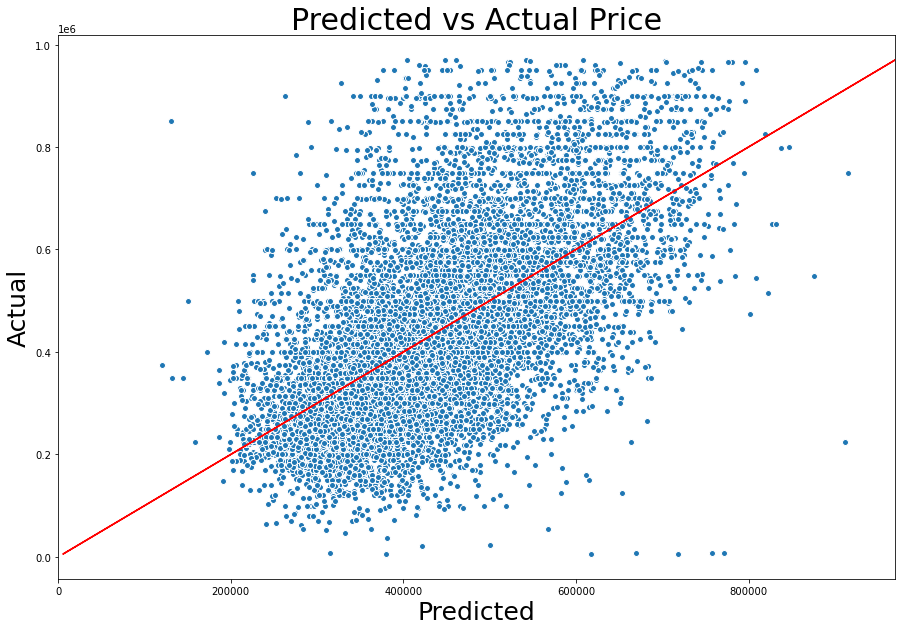

In [8]:
plt.figure(figsize=(15,10))

plt.scatter(results.fittedvalues, outlierGoneDf.latestPrice,edgecolor='white')

plt.xlim(0,outlierGoneDf.latestPrice.max())
plt.xlabel("Predicted",fontsize=25)
plt.ylabel("Actual",fontsize=25)
plt.title("Predicted vs Actual Price",fontsize=30)
plt.plot(outlierGoneDf.latestPrice, outlierGoneDf.latestPrice,color='red')

print(f'R squared is: {results.rsquared}')

plt.show()


In [9]:
#predicted vs actual


In [10]:
#CLean
outlierGoneDf = pd.DataFrame()

In [11]:
squareFoot = cleanDf['livingAreaSqFt']
quartiles = squareFoot.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq



lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

mask = cleanDf['livingAreaSqFt'] < upper_bound
outlierGoneDf = cleanDf[mask]

latestPrice = cleanDf['latestPrice']
quartiles = latestPrice.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq



lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

mask = outlierGoneDf['latestPrice'] < upper_bound
outlierGoneDf = outlierGoneDf[mask]

Values below -320.25 could be outliers.
Values above 4493.75 could be outliers.
Values below -87500.0 could be outliers.
Values above 972500.0 could be outliers.


No handles with labels found to put in legend.


The r-squared is: 0.27955909787961075


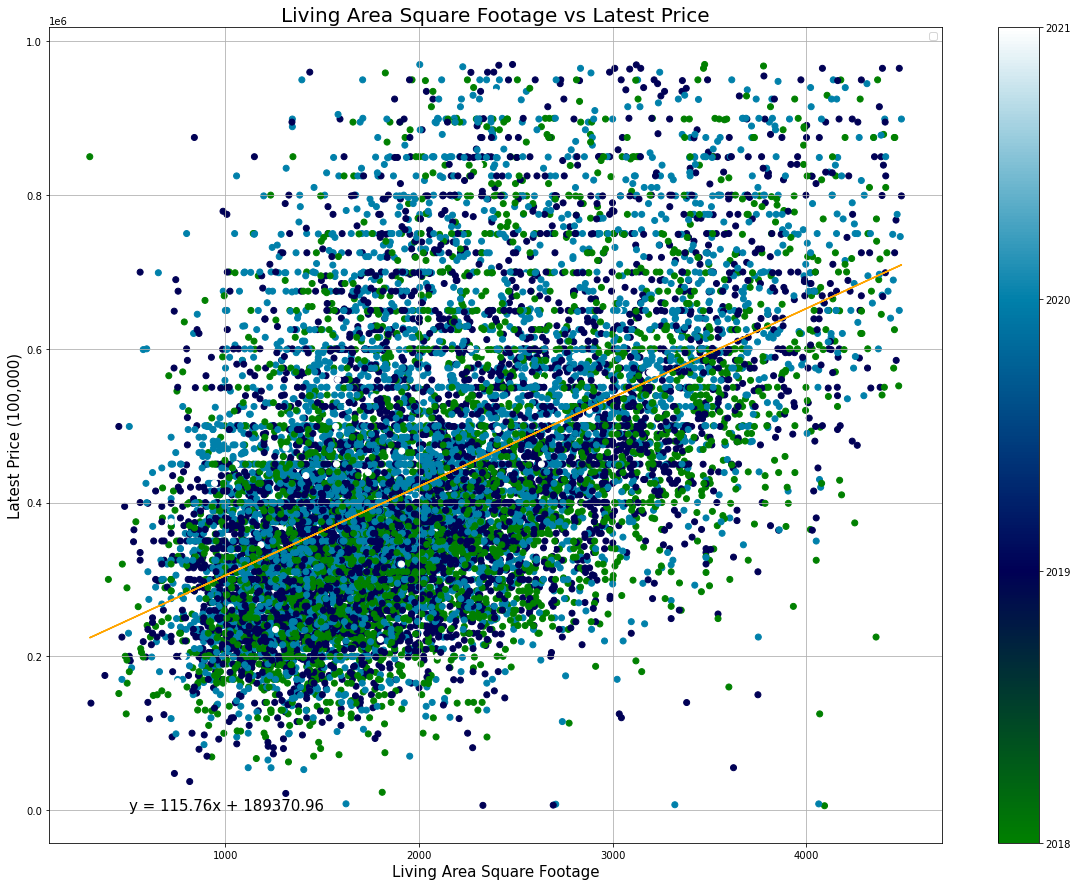

In [15]:
x_values = outlierGoneDf['livingAreaSqFt']
y_values = outlierGoneDf['latestPrice'] 

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

weight = outlierGoneDf.latest_saleyear

plt.figure(figsize=(20, 15))
plt.scatter(x_values,y_values, marker="o",c= weight,cmap='ocean') #facecolors="navy", edgecolors="white")
plt.plot(x_values,regress_values,"r-",color='orange')

plt.annotate(line_eq,(500,0),fontsize=15,color="black")
plt.legend()
plt.title('Living Area Square Footage vs Latest Price', fontsize=20)
plt.xlabel('Living Area Square Footage', fontsize=15)
plt.ylabel('Latest Price (100,000)', fontsize=15)
print(f"The r-squared is: {rvalue**2}")
plt.grid()
plt.colorbar(ticks=[2018,2019,2020,2021])
plt.show()


In [13]:
#Clean
outlierGoneDf = pd.DataFrame()

The r-squared is: 0.008187884334956208


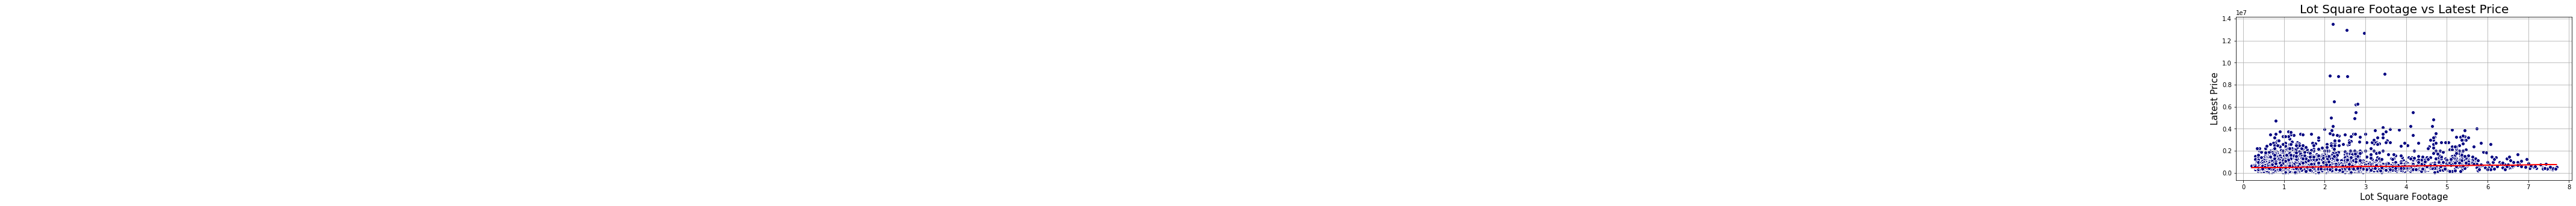

In [14]:
x_values = cleanDf['avgSchoolDistance']
y_values = cleanDf['latestPrice']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10, 5))
plt.scatter(x_values,y_values, marker="o", facecolors="navy", edgecolors="white")
plt.plot(x_values,regress_values,"r-")

plt.annotate(line_eq,(-55,20),fontsize=15,color="red")
plt.title('Lot Square Footage vs Latest Price', fontsize=20)
plt.xlabel('Lot Square Footage', fontsize=15)
plt.ylabel('Latest Price', fontsize=15)
print(f"The r-squared is: {rvalue**2}")
plt.grid()
plt.show()

In [15]:
corr = cleanDf.corr()
corr

,index,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
index,1.000000,-0.034746,-0.154915,-0.093213,0.149799,0.008704,-0.060752,-0.300518,-0.028607,0.006462,...,-0.175070,-0.206991,0.168948,-0.348782,-0.073763,-0.157177,-0.005165,-0.192260,-0.175171,-0.055149
zpid,-0.034746,1.000000,-0.049676,-0.057647,0.004445,-0.010914,-0.003147,0.105609,-0.052192,0.019745,...,-0.005667,-0.002575,0.016044,0.048069,-0.046556,-0.034794,-0.063753,0.053704,-0.038932,0.000045
zipcode,-0.154915,-0.049676,1.000000,-0.095812,-0.073496,-0.220567,-0.029873,0.045137,0.087694,-0.053010,...,0.086754,-0.024694,0.060863,0.014201,-0.006821,0.208909,0.097093,-0.074898,0.028623,-0.077245
latitude,-0.093213,-0.057647,-0.095812,1.000000,0.359819,0.453549,0.018304,-0.052899,0.041893,0.015984,...,0.126261,-0.018028,0.129248,-0.043974,0.259865,0.088073,-0.010138,0.054663,0.080054,0.044665
longitude,0.149799,0.004445,-0.073496,0.359819,1.000000,-0.009408,-0.113697,-0.314505,-0.063300,-0.030106,...,-0.033445,-0.218597,0.455043,-0.279133,-0.549842,-0.352046,-0.597185,-0.334516,-0.286055,-0.159857
propertyTaxRate,0.008704,-0.010914,-0.220567,0.453549,-0.009408,1.000000,0.026065,0.127324,0.034164,0.015572,...,-0.052036,-0.021596,-0.034123,-0.013564,0.183150,0.161133,-0.023461,0.065454,0.098356,0.057732
garageSpaces,-0.060752,-0.003147,-0.029873,0.018304,-0.113697,0.026065,1.000000,0.046093,0.062077,0.822054,...,0.027305,0.044557,-0.063961,0.077575,0.091128,0.036372,0.061673,0.198423,0.163868,0.096055
hasAssociation,-0.300518,0.105609,0.045137,-0.052899,-0.314505,0.127324,0.046093,1.000000,0.079938,0.006434,...,0.125918,0.114921,-0.026586,0.316668,0.309853,0.408884,0.245628,0.339640,0.227193,0.312459
hasCooling,-0.028607,-0.052192,0.087694,0.041893,-0.063300,0.034164,0.062077,0.079938,1.000000,0.056300,...,0.010966,0.010698,-0.005497,0.004030,0.070257,0.106671,0.092267,0.127126,0.119860,0.045590
hasGarage,0.006462,0.019745,-0.053010,0.015984,-0.030106,0.015572,0.822054,0.006434,0.056300,1.000000,...,0.002351,0.013681,-0.023281,0.010981,0.030971,-0.012638,0.008133,0.083895,0.054700,0.068356


<AxesSubplot:>

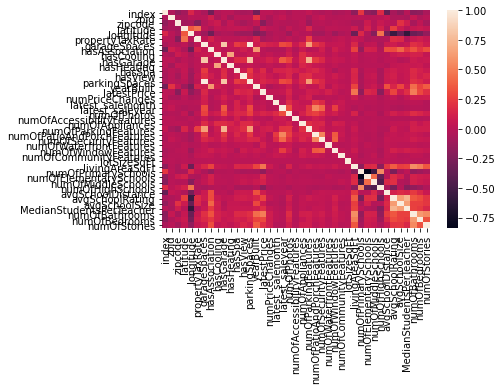

In [16]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [17]:
mask = cleanDf['latestPrice'] < 400000
lowerHouse = cleanDf[mask]
lowerHouse.describe()


,index,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
count,7330.000000,7.330000e+03,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,...,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000,7330.000000
mean,7454.093724,9.557340e+07,78740.461392,30.282020,-97.754186,1.996847,1.023192,1.020464,1988.219509,298776.333970,...,0.026603,1.007640,1.042701,1.800609,4.915888,1188.092906,14.196044,2.281985,3.183220,1.363711
std,3922.171037,2.941511e+08,13.575115,0.104385,0.080502,0.059090,1.204330,1.204379,19.112738,69739.190033,...,0.204937,0.136008,0.280254,0.924953,1.597674,325.566340,1.623326,0.705712,0.729936,0.486458
min,19.000000,2.858495e+07,78653.000000,30.085030,-98.020477,1.980000,0.000000,0.000000,1907.000000,5500.000000,...,0.000000,0.000000,0.000000,0.300000,2.333333,396.000000,10.000000,0.000000,0.000000,1.000000
25%,4107.500000,2.943871e+07,78729.000000,30.192233,-97.813688,1.980000,0.000000,0.000000,1975.000000,250000.000000,...,0.000000,1.000000,1.000000,1.133333,3.666667,925.000000,13.000000,2.000000,3.000000,1.000000
50%,7313.500000,2.950292e+07,78745.000000,30.255078,-97.749294,1.980000,1.000000,0.000000,1987.000000,307900.000000,...,0.000000,1.000000,1.000000,1.600000,4.666667,1189.000000,14.000000,2.000000,3.000000,1.000000
75%,10848.750000,7.033275e+07,78749.000000,30.370018,-97.691690,1.980000,2.000000,2.000000,2005.000000,350000.000000,...,0.000000,1.000000,1.000000,2.233333,6.000000,1476.000000,15.000000,3.000000,4.000000,2.000000
max,15170.000000,2.145703e+09,78759.000000,30.516279,-97.569504,2.210000,22.000000,22.000000,2020.000000,399999.000000,...,2.000000,3.000000,2.000000,7.666667,9.000000,1913.000000,18.000000,8.000000,20.000000,3.000000


In [18]:
mask = cleanDf['latestPrice'] >= 400000
upperHouse = cleanDf[mask]
upperHouse.describe()

,index,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
count,7689.000000,7.689000e+03,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7.689000e+03,...,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000,7689.000000
mean,7827.939914,1.110224e+08,78733.546755,30.301880,-97.803574,1.991663,1.428014,1.421381,1988.468852,7.205607e+05,...,0.069970,1.062817,0.914163,1.878798,6.642639,1281.114319,15.505137,3.066133,3.684484,1.567954
std,4718.528831,3.371813e+08,17.063813,0.087491,0.079756,0.047099,1.450286,1.451914,23.675400,5.582849e+05,...,0.255113,0.342274,0.289279,1.181444,1.678537,320.948715,1.612744,1.182951,0.886111,0.538906
min,17.000000,2.858567e+07,78652.000000,30.115831,-98.022057,1.980000,0.000000,0.000000,1905.000000,4.000000e+05,...,0.000000,0.000000,0.000000,0.200000,2.333333,396.000000,10.000000,0.000000,0.000000,1.000000
25%,3397.000000,2.937252e+07,78723.000000,30.231934,-97.869186,1.980000,0.000000,0.000000,1972.000000,4.650000e+05,...,0.000000,1.000000,1.000000,1.066667,5.666667,1087.000000,15.000000,2.000000,3.000000,1.000000
50%,8026.000000,2.947459e+07,78735.000000,30.300112,-97.782059,1.980000,2.000000,2.000000,1995.000000,5.690000e+05,...,0.000000,1.000000,1.000000,1.500000,7.000000,1332.000000,16.000000,3.000000,4.000000,2.000000
75%,12528.000000,7.033740e+07,78748.000000,30.363478,-97.744202,1.980000,2.000000,2.000000,2007.000000,7.500000e+05,...,0.000000,1.000000,1.000000,2.333333,8.000000,1533.000000,16.000000,4.000000,4.000000,2.000000
max,15169.000000,2.146313e+09,78759.000000,30.517323,-97.578438,2.210000,20.000000,20.000000,2020.000000,1.350000e+07,...,1.000000,3.000000,2.000000,7.700000,9.500000,1913.000000,19.000000,27.000000,10.000000,4.000000


In [19]:
mask = upperHouse['latitude'] >=  30.305683
upperNorthHouse = upperHouse[mask]
upperNorthHouse.describe()

,index,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
count,3710.000000,3.710000e+03,3710.000000,3710.000000,3710.000000,3710.000000,3710.000000,3710.00000,3710.000000,3.710000e+03,...,3710.000000,3710.000000,3710.000000,3710.000000,3710.000000,3710.000000,3710.000000,3710.000000,3710.000000,3710.000000
mean,6674.629380,8.621166e+07,78739.158221,30.378075,-97.783922,2.000768,1.454987,1.44690,1986.536658,7.355617e+05,...,0.108356,1.083019,0.931267,1.814746,7.094434,1354.852291,15.676819,3.134704,3.785714,1.588140
std,5039.086409,2.839335e+08,14.416990,0.051268,0.065068,0.065928,1.422197,1.42457,20.652333,6.565916e+05,...,0.310871,0.416831,0.258307,0.961388,1.435249,231.123218,1.133750,1.237637,0.877606,0.522525
min,17.000000,2.933775e+07,78703.000000,30.305717,-97.932671,1.980000,0.000000,0.00000,1912.000000,4.000000e+05,...,0.000000,0.000000,0.000000,0.366667,2.333333,569.000000,11.000000,0.000000,0.000000,1.000000
25%,2287.250000,2.936338e+07,78730.000000,30.339856,-97.826729,1.980000,0.000000,0.00000,1971.000000,4.749990e+05,...,0.000000,1.000000,1.000000,1.100000,7.000000,1177.000000,15.000000,2.000000,3.000000,1.000000
50%,5875.500000,2.941394e+07,78732.000000,30.365551,-97.767651,1.980000,2.000000,2.00000,1991.000000,5.790000e+05,...,0.000000,1.000000,1.000000,1.633333,7.000000,1381.000000,16.000000,3.000000,4.000000,2.000000
75%,11328.500000,5.830736e+07,78756.000000,30.417325,-97.736454,1.980000,2.000000,2.00000,2003.000000,7.615000e+05,...,0.000000,1.000000,1.000000,2.366667,8.333333,1523.000000,16.000000,4.000000,4.000000,2.000000
max,15162.000000,2.146313e+09,78759.000000,30.517323,-97.578438,2.210000,12.000000,12.00000,2020.000000,1.350000e+07,...,1.000000,3.000000,2.000000,5.666667,9.333333,1913.000000,17.000000,27.000000,8.000000,4.000000


In [20]:
mask = upperHouse['latitude'] <  30.305683
upperSouthHouse = upperHouse[mask]
upperSouthHouse.describe()

,index,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
count,3979.000000,3.979000e+03,3979.000000,3979.000000,3979.000000,3979.000000,3979.000000,3979.000000,3979.000000,3.979000e+03,...,3979.000000,3979.000000,3979.000000,3979.000000,3979.000000,3979.000000,3979.000000,3979.000000,3979.000000,3979.000000
mean,8903.280975,1.341559e+08,78728.314652,30.230835,-97.821897,1.983174,1.402865,1.397587,1990.270420,7.065739e+05,...,0.034179,1.043981,0.898216,1.938520,6.221388,1212.361397,15.345062,3.002199,3.590098,1.549133
std,4117.837271,3.787439e+08,17.668830,0.043358,0.087464,0.009229,1.475730,1.476736,26.055347,4.472141e+05,...,0.181713,0.252341,0.314625,1.352191,1.776697,373.458966,1.942954,1.125979,0.883690,0.553145
min,51.000000,2.858567e+07,78652.000000,30.115831,-98.022057,1.980000,0.000000,0.000000,1905.000000,4.000000e+05,...,0.000000,0.000000,0.000000,0.200000,2.666667,396.000000,10.000000,0.000000,0.000000,1.000000
25%,5362.500000,2.939873e+07,78704.000000,30.192707,-97.886822,1.980000,0.000000,0.000000,1974.000000,4.599000e+05,...,0.000000,1.000000,1.000000,1.066667,4.666667,890.000000,14.000000,2.000000,3.000000,1.000000
50%,9609.000000,2.950207e+07,78737.000000,30.234232,-97.809891,1.980000,2.000000,2.000000,1999.000000,5.500000e+05,...,0.000000,1.000000,1.000000,1.433333,6.000000,1226.000000,16.000000,3.000000,4.000000,2.000000
75%,12852.500000,8.010564e+07,78741.000000,30.264829,-97.755421,1.980000,2.000000,2.000000,2011.000000,7.475370e+05,...,0.000000,1.000000,1.000000,2.300000,7.333333,1600.000000,17.000000,4.000000,4.000000,2.000000
max,15169.000000,2.145191e+09,78751.000000,30.305628,-97.583115,2.010000,20.000000,20.000000,2020.000000,4.850000e+06,...,1.000000,3.000000,2.000000,7.700000,9.500000,1755.000000,19.000000,10.000000,10.000000,4.000000


In [21]:
mask = lowerHouse['latitude'] >= 30.282020
lowerNorthHouse = lowerHouse[mask]
lowerNorthHouse.describe()

,index,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
count,3287.000000,3.287000e+03,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,...,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000
mean,7539.317615,7.122607e+07,78739.619106,30.385483,-97.711425,2.016456,1.009127,1.005476,1984.211743,299728.847581,...,0.046851,1.008823,1.111348,1.749563,5.279979,1155.332826,14.092181,2.259036,3.192577,1.342562
std,4032.158466,2.248041e+08,15.647762,0.057270,0.061055,0.084012,1.167073,1.167096,18.554723,71538.864315,...,0.283866,0.171585,0.347693,0.907710,1.700093,277.733073,1.581338,0.702269,0.786971,0.480374
min,42.000000,2.933002e+07,78653.000000,30.282030,-97.926910,1.980000,0.000000,0.000000,1920.000000,5500.000000,...,0.000000,0.000000,0.000000,0.366667,2.333333,480.000000,11.000000,0.000000,0.000000,1.000000
25%,3590.000000,2.941696e+07,78727.000000,30.346400,-97.744961,1.980000,0.000000,0.000000,1971.000000,250000.000000,...,0.000000,1.000000,1.000000,1.033333,4.000000,1019.000000,13.000000,2.000000,3.000000,1.000000
50%,8269.000000,2.944123e+07,78732.000000,30.375725,-97.698837,1.980000,1.000000,0.000000,1984.000000,309900.000000,...,0.000000,1.000000,1.000000,1.566667,5.000000,1073.000000,14.000000,2.000000,3.000000,1.000000
75%,10993.500000,5.830451e+07,78754.000000,30.429993,-97.674072,1.980000,2.000000,2.000000,1999.000000,359000.000000,...,0.000000,1.000000,1.000000,2.233333,6.666667,1381.000000,15.000000,3.000000,4.000000,2.000000
max,15163.000000,2.143442e+09,78759.000000,30.516279,-97.579430,2.210000,10.000000,10.000000,2020.000000,399999.000000,...,2.000000,3.000000,2.000000,6.000000,9.000000,1913.000000,17.000000,7.000000,20.000000,3.000000


In [22]:
mask = lowerHouse['latitude'] < 30.282020
lowerSouthHouse = lowerHouse[mask]
lowerSouthHouse.describe()

,index,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
count,4043.000000,4.043000e+03,4043.000000,4043.000000,4043.000000,4043.000000,4043.000000,4043.000000,4043.000000,4043.000000,...,4043.000000,4043.000000,4043.000000,4043.000000,4043.000000,4043.000000,4043.000000,4043.000000,4043.000000,4043.000000
mean,7384.805837,1.153680e+08,78741.146179,30.197903,-97.788952,1.980905,1.034628,1.032649,1991.477863,298001.930744,...,0.010141,1.006678,0.986891,1.842109,4.619879,1214.727183,14.280485,2.300643,3.175612,1.380905
std,3829.527426,3.390121e+08,11.577703,0.036172,0.077615,0.005133,1.233817,1.233871,18.941842,68240.167870,...,0.100203,0.098000,0.192836,0.936803,1.443317,357.627854,1.652067,0.708037,0.680054,0.490737
min,19.000000,2.858495e+07,78702.000000,30.085030,-98.020477,1.980000,0.000000,0.000000,1907.000000,6000.000000,...,0.000000,0.000000,0.000000,0.300000,2.666667,396.000000,10.000000,0.000000,0.000000,1.000000
25%,4973.500000,2.948876e+07,78741.000000,30.168521,-97.837498,1.980000,0.000000,0.000000,1979.000000,250000.000000,...,0.000000,1.000000,1.000000,1.200000,3.333333,887.000000,13.000000,2.000000,3.000000,1.000000
50%,6933.000000,2.951144e+07,78745.000000,30.196360,-97.798073,1.980000,0.000000,0.000000,1995.000000,302599.000000,...,0.000000,1.000000,1.000000,1.633333,4.000000,1409.000000,14.000000,2.000000,3.000000,1.000000
75%,10517.500000,7.035748e+07,78748.000000,30.220411,-97.742214,1.980000,2.000000,2.000000,2006.000000,350000.000000,...,0.000000,1.000000,1.000000,2.233333,5.333333,1506.000000,15.000000,3.000000,4.000000,2.000000
max,15170.000000,2.145703e+09,78749.000000,30.281940,-97.569504,2.010000,22.000000,22.000000,2020.000000,399999.000000,...,1.000000,2.000000,2.000000,7.666667,9.000000,1755.000000,18.000000,8.000000,8.000000,3.000000


In [23]:
mask = upperNorthHouse['longitude'] >= -97.783922
upperNorthEastHouse = upperNorthHouse[mask]
upperNorthEastHouse.describe()

,index,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
count,2220.000000,2.220000e+03,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2.220000e+03,...,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000
mean,9471.945946,7.344103e+07,78742.004505,30.377221,-97.739375,2.009113,1.332883,1.322973,1978.728378,6.525474e+05,...,0.005405,0.994144,0.993243,1.453362,6.479485,1285.841892,15.455856,2.746059,3.559910,1.456306
std,4387.952853,2.535432e+08,16.587539,0.056892,0.029241,0.076492,1.356805,1.358867,21.706897,5.152423e+05,...,0.073339,0.076316,0.105928,0.735759,1.450193,255.099662,1.162869,1.110431,0.853124,0.524635
min,1721.000000,2.933775e+07,78703.000000,30.305717,-97.783913,1.980000,0.000000,0.000000,1912.000000,4.000000e+05,...,0.000000,0.000000,0.000000,0.366667,2.333333,569.000000,11.000000,0.000000,0.000000,1.000000
25%,7799.750000,2.936914e+07,78727.000000,30.333085,-97.763090,1.980000,0.000000,0.000000,1962.000000,4.500000e+05,...,0.000000,1.000000,1.000000,0.900000,6.000000,1153.000000,15.000000,2.000000,3.000000,1.000000
50%,8811.500000,2.941660e+07,78751.000000,30.360971,-97.744522,1.980000,2.000000,2.000000,1977.000000,5.390000e+05,...,0.000000,1.000000,1.000000,1.266667,7.000000,1196.000000,16.000000,3.000000,3.000000,1.000000
75%,14304.000000,2.954811e+07,78757.000000,30.417255,-97.723118,1.980000,2.000000,2.000000,1996.250000,6.990000e+05,...,0.000000,1.000000,1.000000,1.834574,7.000000,1486.000000,16.000000,3.000000,4.000000,2.000000
max,15162.000000,2.144047e+09,78759.000000,30.517323,-97.578438,2.210000,12.000000,12.000000,2020.000000,1.300000e+07,...,1.000000,1.000000,2.000000,4.133333,9.000000,1913.000000,17.000000,27.000000,8.000000,4.000000


In [25]:
mask = upperNorthHouse['longitude'] < -97.783922
upperNorthWestHouse = upperNorthHouse[mask]
corr = upperNorthWestHouse.corr()

,index,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,hasCooling,hasGarage,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
index,1.000000,-0.012390,-0.150756,-0.073750,-0.320135,-0.100710,0.058777,0.100830,0.031415,0.080844,...,-0.228764,-0.114408,0.182832,-0.145169,0.084168,0.085404,0.298285,-0.037716,0.049706,0.090773
zpid,-0.012390,1.000000,-0.169080,0.048832,-0.022765,0.024979,-0.025876,0.007580,-0.072020,-0.002748,...,-0.079715,-0.002022,0.031266,-0.053958,-0.148255,-0.110300,-0.018137,-0.015990,-0.046641,-0.093737
zipcode,-0.150756,-0.169080,1.000000,0.070639,0.441263,-0.285632,-0.112655,-0.080648,-0.000544,-0.104116,...,0.443630,-0.073822,-0.097182,-0.277648,0.309949,0.649663,0.086952,-0.140147,-0.088391,-0.080311
latitude,-0.073750,0.048832,0.070639,1.000000,0.499992,0.490312,-0.077509,0.049980,0.042302,-0.031244,...,-0.087222,-0.411979,0.494222,-0.523184,-0.073679,0.017853,-0.005549,-0.256948,-0.076895,-0.174214
longitude,-0.320135,-0.022765,0.441263,0.499992,1.000000,0.247099,-0.137598,-0.084591,-0.015704,-0.130547,...,0.262214,-0.152780,-0.005242,-0.195206,-0.227576,-0.032102,-0.341379,-0.192030,-0.193282,-0.161629
propertyTaxRate,-0.100710,0.024979,-0.285632,0.490312,0.247099,1.000000,-0.027349,0.042942,0.011252,-0.009918,...,-0.107297,-0.072229,0.075202,0.022987,-0.075235,-0.184908,-0.269875,-0.031814,0.001808,-0.050462
garageSpaces,0.058777,-0.025876,-0.112655,-0.077509,-0.137598,-0.027349,1.000000,-0.068847,0.063492,0.861276,...,-0.058577,-0.005320,0.010812,0.079897,0.019028,-0.018109,0.064572,0.214369,0.169976,0.074711
hasAssociation,0.100830,0.007580,-0.080648,0.049980,-0.084591,0.042942,-0.068847,1.000000,0.069765,-0.048322,...,-0.089106,-0.091758,0.077104,-0.181478,0.059331,0.035966,0.081719,0.041667,0.119124,0.077453
hasCooling,0.031415,-0.072020,-0.000544,0.042302,-0.015704,0.011252,0.063492,0.069765,1.000000,0.073719,...,0.008150,-0.017050,0.006145,-0.083149,0.020901,0.044362,0.000350,0.049430,0.095590,0.049253
hasGarage,0.080844,-0.002748,-0.104116,-0.031244,-0.130547,-0.009918,0.861276,-0.048322,0.073719,1.000000,...,-0.074783,-0.011435,0.027002,0.033463,0.033819,-0.011857,0.076384,0.056096,0.069898,0.061573


<AxesSubplot:>

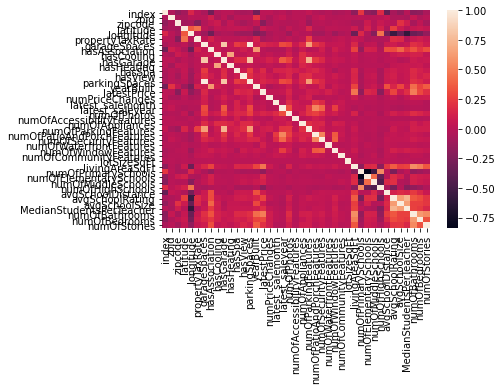

In [26]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [176]:
mask = upperSouthHouse['longitude'] >= -97.821897
upperSouthEastHouse = upperSouthHouse[mask]
upperSouthEastHouse.describe()

,index,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
count,2069.000000,2.069000e+03,2069.000000,2069.000000,2069.000000,2.069000e+03,2069.000000,2069.000000,2069.000000,2.069000e+03,...,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000
mean,10460.088932,1.570946e+08,78717.282745,30.254879,-97.749509,1.980000e+00,1.314161,1.312711,1980.929918,7.814201e+05,...,0.046883,0.996133,0.959401,1.306447,5.223488,1022.260029,14.073465,2.702513,3.262929,1.524891
std,3110.403496,4.434290e+08,17.835640,0.035399,0.038185,1.665737e-14,1.321192,1.321719,31.591818,4.790241e+05,...,0.211438,0.062077,0.231250,0.640537,1.555139,298.451570,1.626490,1.098293,0.891874,0.592493
min,51.000000,2.932187e+07,78701.000000,30.115831,-97.821808,1.980000e+00,0.000000,0.000000,1905.000000,4.000000e+05,...,0.000000,0.000000,0.000000,0.266667,2.666667,396.000000,10.000000,0.000000,0.000000,1.000000
25%,9362.000000,2.938402e+07,78704.000000,30.237232,-97.777084,1.980000e+00,0.000000,0.000000,1954.000000,4.750000e+05,...,0.000000,1.000000,1.000000,0.900000,4.000000,861.000000,13.000000,2.000000,3.000000,1.000000
50%,10228.000000,2.947239e+07,78704.000000,30.255407,-97.757256,1.980000e+00,1.000000,1.000000,1979.000000,6.200000e+05,...,0.000000,1.000000,1.000000,1.166667,5.000000,966.000000,14.000000,3.000000,3.000000,1.000000
75%,13436.000000,7.033841e+07,78741.000000,30.283884,-97.719414,1.980000e+00,2.000000,2.000000,2014.000000,8.750000e+05,...,0.000000,1.000000,1.000000,1.566667,6.666667,1226.000000,15.000000,3.000000,4.000000,2.000000
max,15169.000000,2.145191e+09,78751.000000,30.305628,-97.583115,1.980000e+00,12.000000,12.000000,2020.000000,4.745000e+06,...,1.000000,1.000000,2.000000,6.466667,9.500000,1669.000000,16.000000,8.000000,8.000000,4.000000


In [178]:
mask = upperSouthHouse['longitude'] < -97.821897
upperSouthWestHouse = upperSouthHouse[mask]
upperSouthWestHouse.describe()

,index,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
count,1910.000000,1.910000e+03,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1.910000e+03,...,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000
mean,7216.874869,1.093076e+08,78740.264921,30.204791,-97.900312,1.986613,1.498953,1.489529,2000.388482,6.254971e+05,...,0.020419,1.095812,0.831937,2.623209,7.302359,1418.287958,16.722513,3.326832,3.944503,1.575393
std,4402.466621,2.910707e+08,5.581059,0.035423,0.050302,0.012439,1.621538,1.623442,11.683574,3.943846e+05,...,0.141465,0.351206,0.374020,1.569580,1.307520,335.477547,1.161846,1.064152,0.723807,0.505933
min,225.000000,2.858567e+07,78652.000000,30.129955,-98.022057,1.980000,0.000000,0.000000,1955.000000,4.000000e+05,...,0.000000,0.000000,0.000000,0.200000,3.333333,678.000000,12.000000,0.000000,0.000000,1.000000
25%,4380.250000,2.949171e+07,78737.000000,30.181880,-97.920527,1.980000,0.000000,0.000000,1994.000000,4.500000e+05,...,0.000000,1.000000,1.000000,1.333333,6.000000,1332.000000,16.000000,3.000000,4.000000,1.000000
50%,6141.500000,5.831546e+07,78739.000000,30.195457,-97.888721,1.980000,2.000000,2.000000,2002.000000,5.150000e+05,...,0.000000,1.000000,1.000000,2.166667,7.333333,1576.000000,17.000000,3.000000,4.000000,2.000000
75%,12591.500000,8.382448e+07,78748.000000,30.223396,-97.865742,1.980000,2.000000,2.000000,2009.000000,6.249000e+05,...,0.000000,1.000000,1.000000,3.591667,8.666667,1664.000000,18.000000,4.000000,4.000000,2.000000
max,15164.000000,2.120767e+09,78749.000000,30.303675,-97.821953,2.010000,20.000000,20.000000,2020.000000,4.850000e+06,...,1.000000,3.000000,1.000000,7.700000,9.500000,1755.000000,19.000000,10.000000,10.000000,3.000000


In [ ]:
#clean
    #upper(over 400,000) 
        #North
            #East
            #West
        #South
            #East
            #West
    #lower(under 400,000) 
        #North
            #East
            #West
        #South
            #East
            #West

In [189]:
mask = lowerSouthHouse['longitude'] >= -97.788952
lowerSouthEast = lowerSouthHouse[mask]
lowerSouthEast.describe()

,index,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
count,1774.000000,1.774000e+03,1774.000000,1774.000000,1774.000000,1.774000e+03,1774.000000,1774.00000,1774.000000,1774.000000,...,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000,1774.000000
mean,6128.629087,1.399773e+08,78735.072153,30.208506,-97.721965,1.980000e+00,0.966742,0.96336,1990.236189,274524.717024,...,0.021984,0.997745,1.024803,1.997503,4.002977,1136.262120,13.356821,2.153326,3.078354,1.324690
std,4018.748674,3.734620e+08,14.831347,0.043901,0.057056,1.643593e-14,1.127275,1.12717,23.966630,71264.825991,...,0.146673,0.047444,0.172746,0.826672,0.975478,386.748636,1.359957,0.754118,0.757035,0.477927
min,19.000000,2.932222e+07,78702.000000,30.085030,-97.788925,1.980000e+00,0.000000,0.00000,1910.000000,6000.000000,...,0.000000,0.000000,0.000000,0.300000,2.666667,396.000000,10.000000,0.000000,0.000000,1.000000
25%,2163.250000,2.946788e+07,78725.000000,30.166964,-97.766439,1.980000e+00,0.000000,0.00000,1972.000000,225000.000000,...,0.000000,1.000000,1.000000,1.366667,3.333333,840.000000,12.000000,2.000000,3.000000,1.000000
50%,5605.000000,5.831305e+07,78744.000000,30.205511,-97.738201,1.980000e+00,0.000000,0.00000,2002.000000,274945.000000,...,0.000000,1.000000,1.000000,1.838296,3.666667,1287.000000,14.000000,2.000000,3.000000,1.000000
75%,10242.750000,8.383139e+07,78745.000000,30.240857,-97.694628,1.980000e+00,2.000000,2.00000,2010.000000,325000.000000,...,0.000000,1.000000,1.000000,2.633333,4.333333,1506.000000,14.000000,3.000000,3.000000,2.000000
max,15170.000000,2.142048e+09,78748.000000,30.281940,-97.569504,1.980000e+00,7.000000,7.00000,2020.000000,399999.000000,...,1.000000,1.000000,2.000000,5.366667,9.000000,1600.000000,16.000000,6.000000,8.000000,3.000000


In [190]:
mask = lowerSouthHouse['longitude'] < -97.788952
lowerSouthWest = lowerSouthHouse[mask]
lowerSouthWest.describe()

,index,zpid,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,...,numOfElementarySchools,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories
count,2269.000000,2.269000e+03,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,...,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000
mean,8366.937858,9.612748e+07,78745.895108,30.189613,-97.841324,1.981613,1.087704,1.086822,1992.448656,316357.407669,...,0.000881,1.013662,0.957250,1.720616,5.102200,1276.074482,15.002644,2.415822,3.251653,1.424857
std,3363.260659,3.081366e+08,3.938294,0.025857,0.044016,0.006768,1.308894,1.308953,13.720556,59671.723707,...,0.029683,0.123472,0.202338,0.998076,1.561506,320.042824,1.493074,0.647006,0.602503,0.496211
min,482.000000,2.858495e+07,78735.000000,30.131126,-98.020477,1.980000,0.000000,0.000000,1907.000000,8000.000000,...,0.000000,0.000000,0.000000,0.400000,3.333333,743.000000,12.000000,0.000000,0.000000,1.000000
25%,5405.000000,2.949472e+07,78745.000000,30.168674,-97.854156,1.980000,0.000000,0.000000,1982.000000,279800.000000,...,0.000000,1.000000,1.000000,1.133333,3.666667,890.000000,14.000000,2.000000,3.000000,1.000000
50%,7076.000000,2.950980e+07,78748.000000,30.191002,-97.834206,1.980000,1.000000,1.000000,1994.000000,325000.000000,...,0.000000,1.000000,1.000000,1.433333,4.666667,1424.000000,15.000000,2.000000,3.000000,1.000000
75%,12197.000000,6.465798e+07,78748.000000,30.207644,-97.812141,1.980000,2.000000,2.000000,2004.000000,364900.000000,...,0.000000,1.000000,1.000000,1.866667,6.000000,1494.000000,16.000000,3.000000,4.000000,2.000000
max,15166.000000,2.145703e+09,78749.000000,30.281429,-97.788963,2.010000,22.000000,22.000000,2019.000000,399999.000000,...,1.000000,2.000000,1.000000,7.666667,9.000000,1755.000000,18.000000,8.000000,8.000000,3.000000


In [40]:
cleanDf.columns

Index(['index', 'zpid', 'city', 'streetAddress', 'zipcode', 'description',
       'latitude', 'longitude', 'propertyTaxRate', 'garageSpaces',
       'hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa',
       'hasView', 'homeType', 'parkingSpaces', 'yearBuilt', 'latestPrice',
       'numPriceChanges', 'latest_saledate', 'latest_salemonth',
       'latest_saleyear', 'latestPriceSource', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'homeImage'],
      dtype='object')

In [103]:
x1 = cleanDf['yearBuilt']
quartiles = x1.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq



lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

mask = cleanDf['yearBuilt'] > lower_bound
outlierGoneDf = cleanDf[mask]

y1 = outlierGoneDf['latestPrice']
quartiles = y1.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq



lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

mask = outlierGoneDf['latestPrice'] < upper_bound
outlierGoneDf = outlierGoneDf[mask]

Values below 1926.0 could be outliers.
Values above 2054.0 could be outliers.
Values below -87600.0 could be outliers.
Values above 972400.0 could be outliers.


In [104]:
feature = outlierGoneDf["yearBuilt"]
target = outlierGoneDf["latestPrice"]

# STATSMODELS
X = sm.add_constant(feature)
Y = target

model = sm.OLS(Y,X)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            latestPrice   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.001072
Date:                Sat, 31 Jul 2021   Prob (F-statistic):              0.974
Time:                        11:11:23   Log-Likelihood:            -1.8700e+05
No. Observations:               13874   AIC:                         3.740e+05
Df Residuals:                   13872   BIC:                         3.740e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.313e+05   1.42e+05      3.043      0.002    1.53e+05    7.09e+05
yearBuilt     -2.3336     71.276     -0.033      0.974    -142.045     137.378
==============================================================================
Omnibus:                     1227.188   Durbin-Watson:                   1.379
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1574.122
Skew:                           0.810   Prob(JB):                         0.00
Kurtosis:                       3.310   Cond. No.                     1.92e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

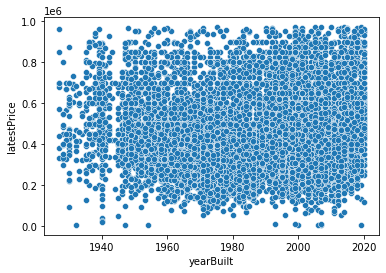

In [107]:
scatter = sns.scatterplot(x=feature,y=target)
#plt.scatter(feature,target, marker="o", facecolors="navy", edgecolors="white")


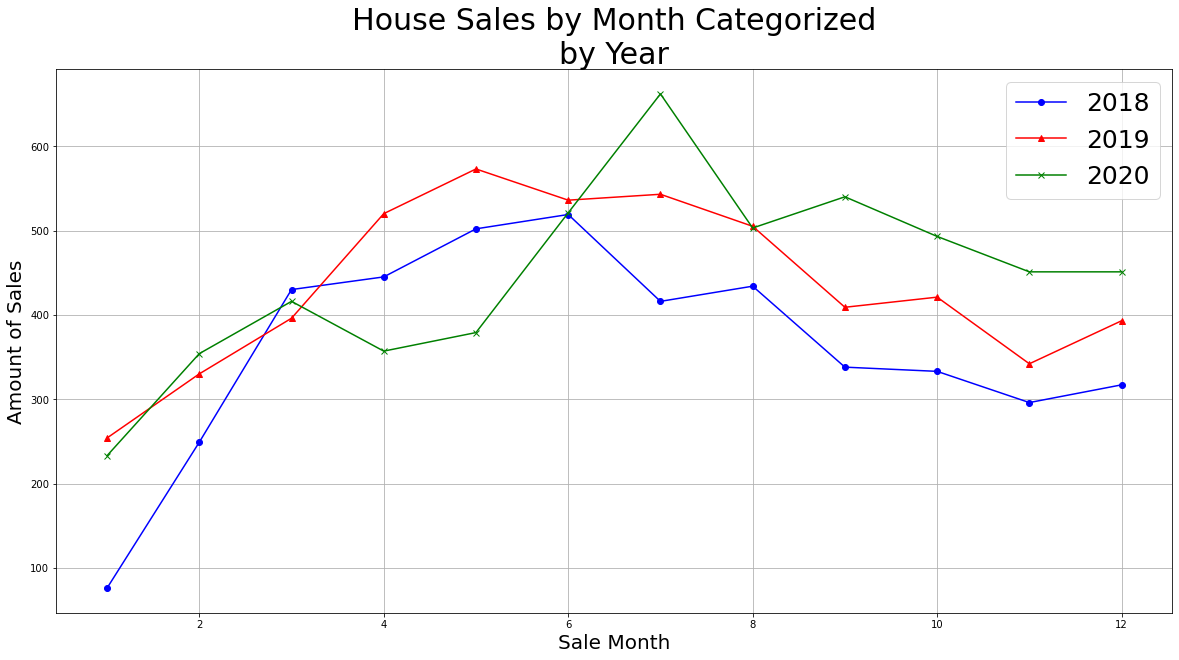

In [213]:
mask = cleanDf["latest_saleyear"] == 2018
sub1 = cleanDf[mask]
sub10 = sub1['latest_salemonth'].value_counts()
sub101 = sub10.sort_index(ascending = True)

mask = cleanDf["latest_saleyear"] == 2019
sub2 = cleanDf[mask]
sub20 = sub2['latest_salemonth'].value_counts()
sub201 = sub20.sort_index(ascending = True)

mask = cleanDf["latest_saleyear"] == 2020
sub3 = cleanDf[mask]
sub30 = sub3['latest_salemonth'].value_counts()
sub301 = sub30.sort_index(ascending = True)

plt.figure(figsize=(20,10))

eighteen, = plt.plot(sub101.index, sub101.values, color="blue", label="2018",marker='o')
nineteen, = plt.plot(sub201.index, sub201.values, color="red", label="2019",marker='^')
twenty, = plt.plot(sub301.index, sub301.values, color="green", label="2020",marker='x')

plt.grid()
plt.title("House Sales by Month Categorized\nby Year",fontsize=30)
plt.xlabel("Sale Month",fontsize=20)
plt.ylabel("Amount of Sales",fontsize=20)
plt.legend(handles=[eighteen,nineteen,twenty ], loc="best",fontsize=25)
plt.show()

In [263]:
latestPrice = upperNorthWestHouse['latestPrice']
quartiles = latestPrice.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq



lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

mask = upperNorthWestHouse['latestPrice'] < upper_bound
outlierGoneDf = upperNorthWestHouse[mask]
outlierGoneDf['latestPrice']

Values below -187.5 could be outliers.
Values above 1400112.5 could be outliers.


0         687850
1         409000
3         400000
4         699000
5         549900
          ...   
13822     540000
13823     619000
13847     475000
13918     564900
14153    1099000
Name: latestPrice, Length: 1355, dtype: int64

In [274]:
outlierGoneDf.columns

Index(['index', 'zpid', 'city', 'streetAddress', 'zipcode', 'description',
       'latitude', 'longitude', 'propertyTaxRate', 'garageSpaces',
       'hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa',
       'hasView', 'homeType', 'parkingSpaces', 'yearBuilt', 'latestPrice',
       'numPriceChanges', 'latest_saledate', 'latest_salemonth',
       'latest_saleyear', 'latestPriceSource', 'numOfPhotos',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'homeImage'],
      dtype='object')

In [276]:
feature = outlierGoneDf[["livingAreaSqFt",'numOfBedrooms','numOfBathrooms','propertyTaxRate','avgSchoolSize']]
target = outlierGoneDf["latestPrice"]

# STATSMODELS
X = sm.add_constant(feature)
Y = target

model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            latestPrice   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     137.9
Date:                Sat, 31 Jul 2021   Prob (F-statistic):          2.89e-118
Time:                        13:53:59   Log-Likelihood:                -18354.
No. Observations:                1355   AIC:                         3.672e+04
Df Residuals:                    1349   BIC:                         3.675e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.743e+06   2.47e+05      7.059      0.000    1.26e+06    2.23e+06
livingAreaSqFt     62.1449      5.395     11.519      0.000      51.562      72.728
numOfBedrooms   -3.419e+04   8197.721     -4.171      0.000   -5.03e+04   -1.81e+04
numOfBathrooms    9.86e+04   7070.584     13.945      0.000    8.47e+04    1.12e+05
propertyTaxRate -6.772e+05   1.14e+05     -5.919      0.000   -9.02e+05   -4.53e+05
avgSchoolSize     -87.3020     38.927     -2.243      0.025    -163.665     -10.939
==============================================================================
Omnibus:                      215.934   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              655.189
Skew:                           0.802   Prob(JB):                    5.34e-143
Kurtosis:                       6.006   Cond. No.                     2.02e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R squared is: 0.3382827674075437


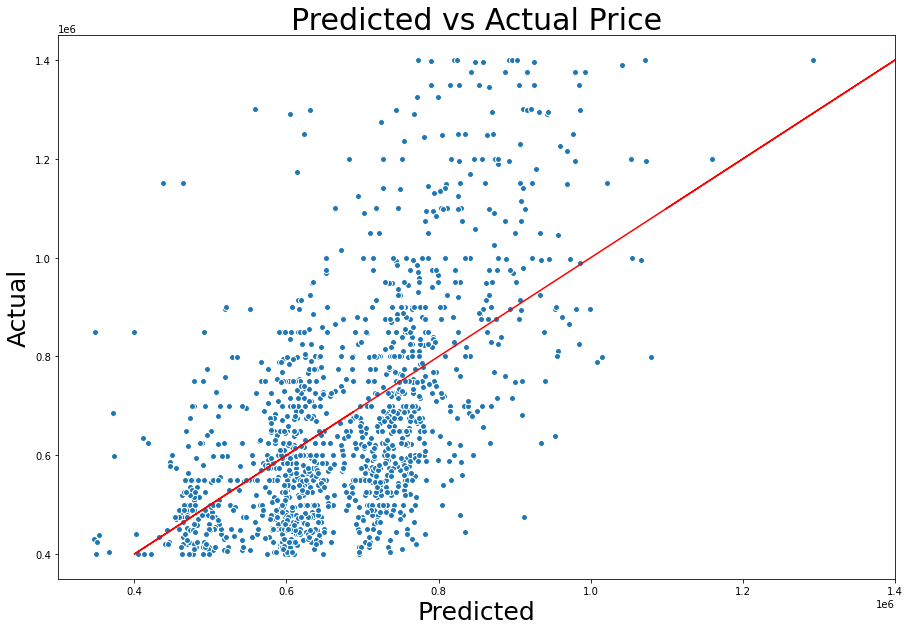

In [278]:
plt.figure(figsize=(15,10))

plt.scatter(results.fittedvalues, outlierGoneDf.latestPrice,edgecolor='white')

plt.xlim(300000,outlierGoneDf.latestPrice.max())
plt.xlabel("Predicted",fontsize=25)
plt.ylabel("Actual",fontsize=25)
plt.title("Predicted vs Actual Price",fontsize=30)
plt.plot(outlierGoneDf.latestPrice, outlierGoneDf.latestPrice,color='red')

print(f'R squared is: {results.rsquared}')

plt.show()